In [1]:
!pip install glob2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from PIL import Image
from glob2 import glob
from keras.preprocessing.image import img_to_array, load_img

  Created wheel for glob2: filename=glob2-0.7-py2.py3-none-any.whl size=9321 sha256=6c0a56524f908e5627159103fe8da59657f069e0ab0038d009efe89e9166f8ae
  Stored in directory: /root/.cache/pip/wheels/d7/3c/72/5300602ba1269ffce8cff5dcf7b525fee756b57455903c37ba
Successfully built glob2


In [2]:
img_width, img_height = (32,32)
if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [3]:
train_path = sorted(glob('../input/arabic-hwr-ai-pro-intake1/train/*.png'))


In [4]:
X=[]
for i in train_path:
    im = img_to_array(Image.open(i).convert('L'))
    # im = (im > 30) * 255
    X.append(im)
X = np.array(X)
X.shape

(13440, 32, 32, 1)

In [5]:
alpha = 'أ ب ت ث ج ح خ د ذ ر ز س ش ص ض ط ظ ع غ ف ق ك ل م ن هـ و ي'
alpha = alpha.split()
m = {i+1: alpha[i] for i in range(len(alpha))}
len(alpha)

28

In [6]:
y_df = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/train.csv')
y_df['alpha'] = y_df.label.map(m)
y_df.head()

,id,label,alpha
0,0,24,م
1,1,2,ب
2,2,17,ظ
3,3,14,ص
4,4,19,غ


Text(0.5, 1.0, 'س')

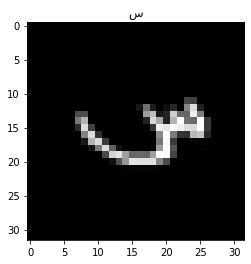

In [7]:
z = X[111].reshape(32,32)
# z = (z > 30) * 255
plt.imshow(z,cmap='gray',)
plt.title(y_df.alpha[111])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(0)

In [9]:
y = y_df.label.values
y = OneHotEncoder(sparse=False).fit_transform(y.reshape(-1,1))
y.shape

(13440, 28)

In [10]:
random_seed = 42

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=random_seed,stratify=y)

In [11]:
# Start neural network
network = Sequential()
# Add convolutional layer with 32 filters, a 3x3 window, and ReLU activation function
network.add(Conv2D(filters=64,kernel_size=(3, 3),
                   padding='same',
                   input_shape=(32, 32, 1),
                   activation='relu'))
# Add max pooling layer with a 2x2 window
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer
network.add(Dropout(0.3))
# Add convolutional layer with 64 filters, a 3x3 window, and ReLU activation function
network.add(Conv2D(filters=128,padding='same',
                   kernel_size=(3, 3),
                   activation='relu'))
# Add max pooling layer with a 2x2 window
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer
network.add(Dropout(0.3))

network.add(Conv2D(filters=256, padding='same',
                   kernel_size=(3, 3),
                   activation='relu'))
# Add max pooling layer with a 2x2 window
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))

# Add layer to flatten input
network.add(Flatten())

# Add fully connected layer of 128 units with a ReLU activation function
network.add(Dense(4096, activation="relu"))
network.add(Dropout(0.3))

network.add(Dense(1024, activation="relu"))
network.add(Dropout(0.3))

# Add fully connected layer of 128 units with a ReLU activation function
network.add(Dense(512, activation="relu"))
network.add(Dropout(0.3))

# Add fully connected layer with a softmax activation function
network.add(Dense(28, activation="softmax"))

# Compile neural network
optimizer = Adam(learning_rate=0.001)
network.compile(loss="categorical_crossentropy", # Cross-entropy
                optimizer=optimizer, # Root Mean Square Propagation                
                metrics=["accuracy"],) # Accuracy performance metric

2021-11-07 11:29:30.525301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 11:29:30.633786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 11:29:30.634525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 11:29:30.635707: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

In [13]:
datagen = ImageDataGenerator(
    rotation_range=20, 
    zoom_range = 0.2, 
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=False,  
    vertical_flip=False)  


datagen.fit(X_train)

In [14]:
epochs = 300
batch_size = 128

history = network.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1)

2021-11-07 11:29:33.297751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2021-11-07 11:29:34.825157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/79 [==============================] - 11s 48ms/step - loss: 3.3853 - accuracy: 0.1256 - val_loss: 3.0771 - val_accuracy: 0.1310
Epoch 2/300
79/79 [==============================] - 3s 41ms/step - loss: 2.1841 - accuracy: 0.2931 - val_loss: 1.2703 - val_accuracy: 0.5560
Epoch 3/300
79/79 [==============================] - 4s 48ms/step - loss: 1.4931 - accuracy: 0.4801 - val_loss: 0.9238 - val_accuracy: 0.6539
Epoch 4/300
79/79 [==============================] - 3s 43ms/step - loss: 1.1731 - accuracy: 0.5975 - val_loss: 0.6684 - val_accuracy: 0.7432
Epoch 5/300
79/79 [==============================] - 3s 42ms/step - loss: 0.9569 - accuracy: 0.6689 - val_loss: 0.7877 - val_accuracy: 0.7417
Epoch 6/300
79/79 [==============================] - 3s 42ms/step - loss: 0.7894 - accuracy: 0.7367 - val_loss: 0.4207 - val_accuracy: 0.8515
Epoch 7/300
79/79 [==============================] - 3s 42ms/step - loss: 0.6750 - accuracy: 0.7695 - val_loss: 0.3169 - val_accuracy: 0.8762
Epoch 8/300
79/79

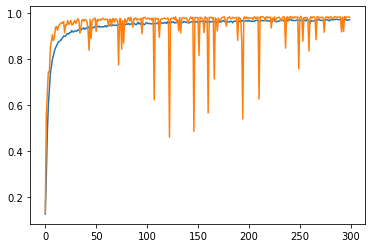

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

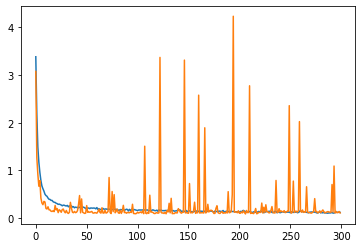

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

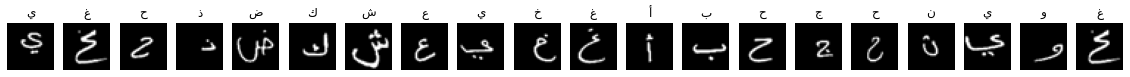

In [17]:
n = 20
r = np.random.randint(0,len(X_val),size = n)
fig,axs = plt.subplots(1,n)
fig.set_size_inches(20, 3)

for i in range(n):
  pred = network.predict(X_val[r[i]].reshape(1,32,32,1))
  axs[i].imshow(X_val[r[i]].reshape(32,32),cmap='gray')
  axs[i].title.set_text(m[pred.argmax()+1])
  axs[i].axis('off')
plt.show()

In [18]:
test_path = sorted(glob('../input/arabic-hwr-ai-pro-intake1/test/*.png'))
Xtest=[]
for i in test_path:
    im = img_to_array(Image.open(i).convert('L'))
    Xtest.append(im)
Xtest = np.array(Xtest)
Xtest.shape

(3360, 32, 32, 1)

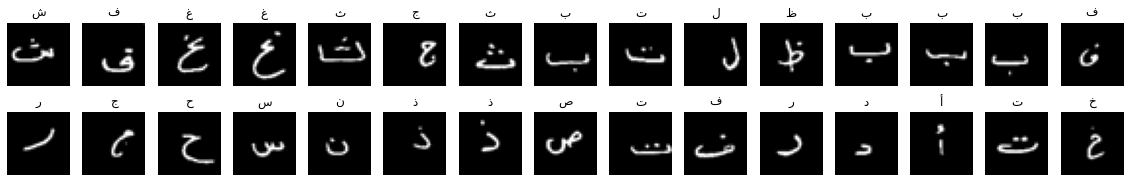

In [19]:
n = 30
r = np.random.randint(0,len(Xtest),size = n)
fig,axs = plt.subplots(2,n//2)
fig.set_size_inches(20, 3)

for i in range(n//2):
  pred = network.predict(Xtest[r[i]].reshape(1,32,32,1))
  axs[0][i].imshow(Xtest[r[i]].reshape(32,32),cmap='gray')
  axs[0][i].title.set_text(m[pred.argmax()+1])
  axs[0][i].axis('off')

for i in range(n//2):
  pred = network.predict(Xtest[r[i+n//2]].reshape(1,32,32,1))
  axs[1][i].imshow(Xtest[r[i+n//2]].reshape(32,32),cmap='gray')
  axs[1][i].title.set_text(m[pred.argmax()+1])
  axs[1][i].axis('off')


plt.show()

In [20]:
pred = network.predict(Xtest)
preds = pred.argmax(axis=1)+1

In [21]:
submission = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/sample_submission.csv')


In [22]:
submission.head()

,id,label
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [23]:
submission['label'] = preds
submission.head()

,id,label
0,0,26
1,1,10
2,2,1
3,3,10
4,4,15


In [24]:
submission.to_csv('submission.csv',index=False)